In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image

c:\Users\Bastien Faivre\.conda\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import *
from utils import *
from model import UNET

In [3]:
IMAGE_HEIGHT = 400
TEST_IMAGE_HEIGHT = 608
IMAGE_WIDTH = 400
TEST_IMAGE_WIDTH = 608
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
TRAIN_IMAGE_DIR = "train_data/train_images/"
TRAIN_GROUNDTRUTH_DIR = "train_data/train_masks/"
VAL_IMAGE_DIR = "train_data/val_images/"
VAL_GROUNDTRUTH_DIR = "train_data/val_masks/"
TEST_IMAGE_DIR = "test_data/"
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
NUM_EPOCHS = 100

In [4]:
# define transformations
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [5]:
# create model
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
# define loss function, optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [6]:
# load data
train_loader, val_loader = get_loaders(
    TRAIN_IMAGE_DIR,
    TRAIN_GROUNDTRUTH_DIR,
    VAL_IMAGE_DIR,
    VAL_GROUNDTRUTH_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY
)

In [7]:
# compute F1 score
def f1_score(predictions, targets):
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > 0.5).float()
    tp = (predictions * targets).sum()
    fp = ((1 - targets) * predictions).sum()
    fn = (targets * (1 - predictions)).sum()
    f1 = (2 * tp) / (2 * tp + fp + fn)
    return f1

In [8]:
def train_epoch(model, optimizer, criterion, train_loader, epoch, device):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    train_loss = 0
    train_f1 = 0
    for _, (data, target) in enumerate(tqdm(train_loader)):
        # move data to device
        data, target = data.to(device), target.unsqueeze(1).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # predict
        predictions = model(data)
        # compute loss and gradients
        loss = criterion(predictions, target)
        loss.backward()
        # update weights
        optimizer.step()
        # compute loss and f1 score
        train_loss += loss.item()
        train_f1 += f1_score(predictions, target)
    # compute average loss and f1 score
    train_loss /= len(train_loader)
    train_f1 /= len(train_loader)
    print('Train set: Average loss: {:.4f}\tAverage F1: {:.4f}'.format(train_loss, train_f1))
    return train_loss, train_f1

In [9]:
@torch.no_grad()
def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    val_f1 = 0
    for _, (data, target) in enumerate(val_loader):
        # move data to device
        data, target = data.to(device), target.unsqueeze(1).to(device)
        # predict
        predictions = model(data)
        # compute loss and f1 score
        val_loss += criterion(predictions, target).item()
        val_f1 += f1_score(predictions, target)
    # compute average loss and f1 score
    val_loss /= len(val_loader)
    val_f1 /= len(val_loader)
    print('Validation set: Average loss: {:.4f}\tAverage F1: {:.4f}'.format(val_loss, val_f1))
    model.train()
    return val_loss, val_f1

In [10]:
# train model

train_loss_history = []
train_f1_history = []
val_loss_history = []
val_f1_history = []

for epoch in range(NUM_EPOCHS):

    train_loss, train_f1 = train_epoch(model, optimizer, criterion, train_loader, epoch, DEVICE)

    train_loss_history.append(train_loss)
    train_f1_history.append(train_f1)

    val_loss, val_f1 = validate(model, criterion, val_loader, DEVICE)

    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    
    save_checkpoint(checkpoint)

    save_predictions_as_imgs(
        val_loader, model, folder="saved_images/", device=DEVICE
    )

Epoch 1/100


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Train set: Average loss: 0.5674	Average F1: 0.4409
Validation set: Average loss: 0.8440	Average F1: 0.3438
=> Saving checkpoint
Epoch 2/100


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Train set: Average loss: 0.4816	Average F1: 0.5591
Validation set: Average loss: 0.6230	Average F1: 0.4567
=> Saving checkpoint
Epoch 3/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.4126	Average F1: 0.6525
Validation set: Average loss: 0.5528	Average F1: 0.5931
=> Saving checkpoint
Epoch 4/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.3824	Average F1: 0.6670
Validation set: Average loss: 0.3961	Average F1: 0.6584
=> Saving checkpoint
Epoch 5/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.3433	Average F1: 0.7108
Validation set: Average loss: 0.3354	Average F1: 0.6814
=> Saving checkpoint
Epoch 6/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.3158	Average F1: 0.7300
Validation set: Average loss: 0.3592	Average F1: 0.6717
=> Saving checkpoint
Epoch 7/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.3049	Average F1: 0.7304
Validation set: Average loss: 0.3160	Average F1: 0.6367
=> Saving checkpoint
Epoch 8/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2880	Average F1: 0.7487
Validation set: Average loss: 0.3110	Average F1: 0.6886
=> Saving checkpoint
Epoch 9/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2779	Average F1: 0.7609
Validation set: Average loss: 0.3060	Average F1: 0.6835
=> Saving checkpoint
Epoch 10/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2653	Average F1: 0.7760
Validation set: Average loss: 0.3019	Average F1: 0.6749
=> Saving checkpoint
Epoch 11/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2624	Average F1: 0.7690
Validation set: Average loss: 0.3516	Average F1: 0.6916
=> Saving checkpoint
Epoch 12/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2496	Average F1: 0.7820
Validation set: Average loss: 0.3113	Average F1: 0.6599
=> Saving checkpoint
Epoch 13/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2496	Average F1: 0.7793
Validation set: Average loss: 0.2796	Average F1: 0.7097
=> Saving checkpoint
Epoch 14/100


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Train set: Average loss: 0.2377	Average F1: 0.7941
Validation set: Average loss: 0.2765	Average F1: 0.7102
=> Saving checkpoint
Epoch 15/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.2238	Average F1: 0.8197
Validation set: Average loss: 0.2672	Average F1: 0.7461
=> Saving checkpoint
Epoch 16/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.2311	Average F1: 0.7976
Validation set: Average loss: 0.3185	Average F1: 0.5388
=> Saving checkpoint
Epoch 17/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.2306	Average F1: 0.8022
Validation set: Average loss: 0.2715	Average F1: 0.7392
=> Saving checkpoint
Epoch 18/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2174	Average F1: 0.8133
Validation set: Average loss: 0.2530	Average F1: 0.7503
=> Saving checkpoint
Epoch 19/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2114	Average F1: 0.8160
Validation set: Average loss: 0.2607	Average F1: 0.7228
=> Saving checkpoint
Epoch 20/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.2004	Average F1: 0.8312
Validation set: Average loss: 0.2470	Average F1: 0.7474
=> Saving checkpoint
Epoch 21/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1937	Average F1: 0.8364
Validation set: Average loss: 0.2444	Average F1: 0.7524
=> Saving checkpoint
Epoch 22/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1900	Average F1: 0.8414
Validation set: Average loss: 0.2541	Average F1: 0.7213
=> Saving checkpoint
Epoch 23/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1920	Average F1: 0.8324
Validation set: Average loss: 0.2381	Average F1: 0.7138
=> Saving checkpoint
Epoch 24/100


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Train set: Average loss: 0.1917	Average F1: 0.8322
Validation set: Average loss: 0.2444	Average F1: 0.7478
=> Saving checkpoint
Epoch 25/100


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Train set: Average loss: 0.1827	Average F1: 0.8423
Validation set: Average loss: 0.2546	Average F1: 0.6983
=> Saving checkpoint
Epoch 26/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1799	Average F1: 0.8465
Validation set: Average loss: 0.2236	Average F1: 0.7500
=> Saving checkpoint
Epoch 27/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1943	Average F1: 0.8206
Validation set: Average loss: 0.2383	Average F1: 0.7472
=> Saving checkpoint
Epoch 28/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1808	Average F1: 0.8389
Validation set: Average loss: 0.2244	Average F1: 0.7455
=> Saving checkpoint
Epoch 29/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1789	Average F1: 0.8417
Validation set: Average loss: 0.2147	Average F1: 0.7858
=> Saving checkpoint
Epoch 30/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1751	Average F1: 0.8421
Validation set: Average loss: 0.2210	Average F1: 0.7837
=> Saving checkpoint
Epoch 31/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1756	Average F1: 0.8387
Validation set: Average loss: 0.2270	Average F1: 0.7380
=> Saving checkpoint
Epoch 32/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1811	Average F1: 0.8228
Validation set: Average loss: 0.2243	Average F1: 0.7509
=> Saving checkpoint
Epoch 33/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1677	Average F1: 0.8473
Validation set: Average loss: 0.2165	Average F1: 0.7842
=> Saving checkpoint
Epoch 34/100


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Train set: Average loss: 0.1748	Average F1: 0.8352
Validation set: Average loss: 0.2245	Average F1: 0.7641
=> Saving checkpoint
Epoch 35/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1626	Average F1: 0.8547
Validation set: Average loss: 0.2194	Average F1: 0.7865
=> Saving checkpoint
Epoch 36/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1558	Average F1: 0.8616
Validation set: Average loss: 0.2567	Average F1: 0.6978
=> Saving checkpoint
Epoch 37/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1514	Average F1: 0.8674
Validation set: Average loss: 0.1963	Average F1: 0.7976
=> Saving checkpoint
Epoch 38/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1549	Average F1: 0.8605
Validation set: Average loss: 0.2363	Average F1: 0.6992
=> Saving checkpoint
Epoch 39/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1514	Average F1: 0.8620
Validation set: Average loss: 0.2064	Average F1: 0.7655
=> Saving checkpoint
Epoch 40/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1478	Average F1: 0.8649
Validation set: Average loss: 0.2005	Average F1: 0.7791
=> Saving checkpoint
Epoch 41/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1453	Average F1: 0.8709
Validation set: Average loss: 0.2259	Average F1: 0.7355
=> Saving checkpoint
Epoch 42/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1441	Average F1: 0.8699
Validation set: Average loss: 0.1975	Average F1: 0.7786
=> Saving checkpoint
Epoch 43/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1378	Average F1: 0.8740
Validation set: Average loss: 0.2056	Average F1: 0.7739
=> Saving checkpoint
Epoch 44/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1396	Average F1: 0.8736
Validation set: Average loss: 0.2253	Average F1: 0.7516
=> Saving checkpoint
Epoch 45/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1319	Average F1: 0.8794
Validation set: Average loss: 0.1831	Average F1: 0.8084
=> Saving checkpoint
Epoch 46/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1335	Average F1: 0.8749
Validation set: Average loss: 0.2156	Average F1: 0.7580
=> Saving checkpoint
Epoch 47/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1406	Average F1: 0.8692
Validation set: Average loss: 0.2278	Average F1: 0.7490
=> Saving checkpoint
Epoch 48/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1397	Average F1: 0.8702
Validation set: Average loss: 0.1942	Average F1: 0.7871
=> Saving checkpoint
Epoch 49/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1351	Average F1: 0.8716
Validation set: Average loss: 0.2031	Average F1: 0.7637
=> Saving checkpoint
Epoch 50/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1335	Average F1: 0.8726
Validation set: Average loss: 0.1997	Average F1: 0.7664
=> Saving checkpoint
Epoch 51/100


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Train set: Average loss: 0.1263	Average F1: 0.8839
Validation set: Average loss: 0.2230	Average F1: 0.7804
=> Saving checkpoint
Epoch 52/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1314	Average F1: 0.8747
Validation set: Average loss: 0.2163	Average F1: 0.7585
=> Saving checkpoint
Epoch 53/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1325	Average F1: 0.8758
Validation set: Average loss: 0.1958	Average F1: 0.7735
=> Saving checkpoint
Epoch 54/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1274	Average F1: 0.8828
Validation set: Average loss: 0.1988	Average F1: 0.7791
=> Saving checkpoint
Epoch 55/100


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Train set: Average loss: 0.1277	Average F1: 0.8777
Validation set: Average loss: 0.2072	Average F1: 0.7539
=> Saving checkpoint
Epoch 56/100


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Train set: Average loss: 0.1276	Average F1: 0.8771
Validation set: Average loss: 0.1957	Average F1: 0.7816
=> Saving checkpoint
Epoch 57/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1218	Average F1: 0.8833
Validation set: Average loss: 0.1876	Average F1: 0.7835
=> Saving checkpoint
Epoch 58/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1164	Average F1: 0.8926
Validation set: Average loss: 0.2152	Average F1: 0.7559
=> Saving checkpoint
Epoch 59/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1253	Average F1: 0.8719
Validation set: Average loss: 0.1982	Average F1: 0.7713
=> Saving checkpoint
Epoch 60/100


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Train set: Average loss: 0.1220	Average F1: 0.8857
Validation set: Average loss: 0.2080	Average F1: 0.7821
=> Saving checkpoint
Epoch 61/100


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Train set: Average loss: 0.1215	Average F1: 0.8838
Validation set: Average loss: 0.2138	Average F1: 0.7614
=> Saving checkpoint
Epoch 62/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1207	Average F1: 0.8840
Validation set: Average loss: 0.2220	Average F1: 0.7441
=> Saving checkpoint
Epoch 63/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1241	Average F1: 0.8796
Validation set: Average loss: 0.2040	Average F1: 0.7828
=> Saving checkpoint
Epoch 64/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1163	Average F1: 0.8863
Validation set: Average loss: 0.1943	Average F1: 0.7916
=> Saving checkpoint
Epoch 65/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1143	Average F1: 0.8896
Validation set: Average loss: 0.2019	Average F1: 0.7846
=> Saving checkpoint
Epoch 66/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1181	Average F1: 0.8854
Validation set: Average loss: 0.2009	Average F1: 0.7975
=> Saving checkpoint
Epoch 67/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1170	Average F1: 0.8907
Validation set: Average loss: 0.1881	Average F1: 0.8064
=> Saving checkpoint
Epoch 68/100


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Train set: Average loss: 0.1136	Average F1: 0.8884
Validation set: Average loss: 0.1826	Average F1: 0.8037
=> Saving checkpoint
Epoch 69/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1071	Average F1: 0.8968
Validation set: Average loss: 0.1798	Average F1: 0.8022
=> Saving checkpoint
Epoch 70/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1039	Average F1: 0.8992
Validation set: Average loss: 0.1835	Average F1: 0.8037
=> Saving checkpoint
Epoch 71/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1067	Average F1: 0.8974
Validation set: Average loss: 0.1802	Average F1: 0.8123
=> Saving checkpoint
Epoch 72/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1082	Average F1: 0.8970
Validation set: Average loss: 0.2230	Average F1: 0.7536
=> Saving checkpoint
Epoch 73/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1064	Average F1: 0.8960
Validation set: Average loss: 0.1817	Average F1: 0.8027
=> Saving checkpoint
Epoch 74/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1062	Average F1: 0.8966
Validation set: Average loss: 0.1932	Average F1: 0.7958
=> Saving checkpoint
Epoch 75/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0986	Average F1: 0.9041
Validation set: Average loss: 0.2054	Average F1: 0.7658
=> Saving checkpoint
Epoch 76/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0974	Average F1: 0.9078
Validation set: Average loss: 0.2218	Average F1: 0.7557
=> Saving checkpoint
Epoch 77/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1096	Average F1: 0.8937
Validation set: Average loss: 0.1903	Average F1: 0.7928
=> Saving checkpoint
Epoch 78/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1131	Average F1: 0.8864
Validation set: Average loss: 0.1819	Average F1: 0.8116
=> Saving checkpoint
Epoch 79/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1063	Average F1: 0.8953
Validation set: Average loss: 0.2216	Average F1: 0.7580
=> Saving checkpoint
Epoch 80/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.1015	Average F1: 0.9024
Validation set: Average loss: 0.1789	Average F1: 0.8099
=> Saving checkpoint
Epoch 81/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0980	Average F1: 0.9046
Validation set: Average loss: 0.2025	Average F1: 0.7699
=> Saving checkpoint
Epoch 82/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0960	Average F1: 0.9052
Validation set: Average loss: 0.1677	Average F1: 0.8402
=> Saving checkpoint
Epoch 83/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.0964	Average F1: 0.9050
Validation set: Average loss: 0.1894	Average F1: 0.8115
=> Saving checkpoint
Epoch 84/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1049	Average F1: 0.8939
Validation set: Average loss: 0.1854	Average F1: 0.8087
=> Saving checkpoint
Epoch 85/100


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Train set: Average loss: 0.1024	Average F1: 0.8982
Validation set: Average loss: 0.1920	Average F1: 0.8136
=> Saving checkpoint
Epoch 86/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1074	Average F1: 0.8942
Validation set: Average loss: 0.1954	Average F1: 0.7909
=> Saving checkpoint
Epoch 87/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.1005	Average F1: 0.9000
Validation set: Average loss: 0.1899	Average F1: 0.7922
=> Saving checkpoint
Epoch 88/100


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Train set: Average loss: 0.0990	Average F1: 0.8999
Validation set: Average loss: 0.1870	Average F1: 0.8039
=> Saving checkpoint
Epoch 89/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0931	Average F1: 0.9076
Validation set: Average loss: 0.1691	Average F1: 0.8293
=> Saving checkpoint
Epoch 90/100


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Train set: Average loss: 0.0887	Average F1: 0.9136
Validation set: Average loss: 0.1685	Average F1: 0.8362
=> Saving checkpoint
Epoch 91/100


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Train set: Average loss: 0.0883	Average F1: 0.9129
Validation set: Average loss: 0.1981	Average F1: 0.7991
=> Saving checkpoint
Epoch 92/100


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Train set: Average loss: 0.0896	Average F1: 0.9087
Validation set: Average loss: 0.1893	Average F1: 0.7998
=> Saving checkpoint
Epoch 93/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0865	Average F1: 0.9145
Validation set: Average loss: 0.1857	Average F1: 0.7924
=> Saving checkpoint
Epoch 94/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.0913	Average F1: 0.9099
Validation set: Average loss: 0.2155	Average F1: 0.7715
=> Saving checkpoint
Epoch 95/100


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Train set: Average loss: 0.0917	Average F1: 0.9083
Validation set: Average loss: 0.1919	Average F1: 0.7925
=> Saving checkpoint
Epoch 96/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0869	Average F1: 0.9138
Validation set: Average loss: 0.1730	Average F1: 0.8137
=> Saving checkpoint
Epoch 97/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0875	Average F1: 0.9135
Validation set: Average loss: 0.2052	Average F1: 0.7931
=> Saving checkpoint
Epoch 98/100


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Train set: Average loss: 0.0862	Average F1: 0.9137
Validation set: Average loss: 0.1887	Average F1: 0.7984
=> Saving checkpoint
Epoch 99/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.0864	Average F1: 0.9144
Validation set: Average loss: 0.1843	Average F1: 0.7986
=> Saving checkpoint
Epoch 100/100


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Train set: Average loss: 0.0846	Average F1: 0.9167
Validation set: Average loss: 0.1886	Average F1: 0.8109
=> Saving checkpoint


In [11]:
#torch.cuda.empty_cache()

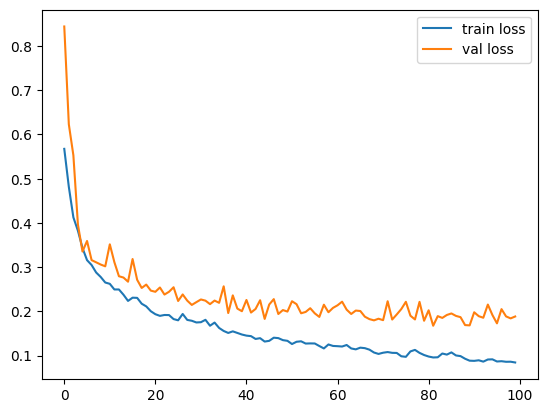

In [12]:
# plot loss and F1 score
plt.plot(train_loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.show()

In [24]:
# define test transforms
test_pre_transforms = A.Compose(
    [
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)
test_post_transforms = A.Compose(
    [
        A.Resize(height=TEST_IMAGE_HEIGHT, width=TEST_IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [25]:
# predict on test image
def predict_image(image, image_folder, model, device):
    model.eval()
    image = test_pre_transforms(image=image)["image"]
    image = image.unsqueeze(0).to(device)
    prediction = model(image)
    prediction = torch.sigmoid(prediction)
    prediction = (prediction > 0.5).float()
    prediction = prediction.squeeze(0).squeeze(0)
    prediction = test_post_transforms(image=prediction.cpu().numpy())["image"]
    torchvision.utils.save_image(
        torch.tensor(prediction), TEST_IMAGE_DIR + image_folder + "/" + image_folder + "_pred.png"
    )

In [26]:
# load and predict on all test images
for image_folder in os.listdir(TEST_IMAGE_DIR):
    img = cv2.imread(TEST_IMAGE_DIR + image_folder + "/" + image_folder + ".png")
    img = np.array(img)
    predict_image(img, image_folder, model, DEVICE)

C:\Users\Bastien Faivre\AppData\Local\Temp\ipykernel_20916\1062265996.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(prediction), TEST_IMAGE_DIR + image_folder + "/" + image_folder + "_pred.png"


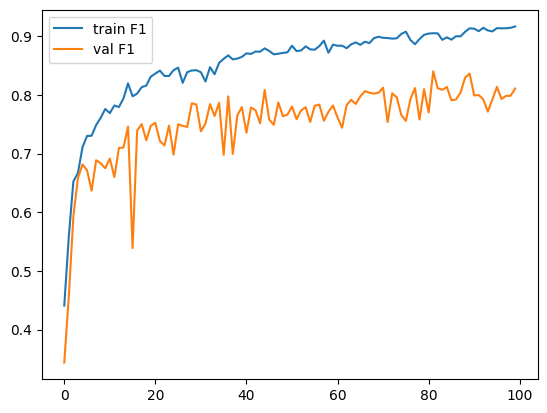

In [27]:
# plot F1 score
train_f1_history = [f.cpu() for f in train_f1_history]
val_f1_history = [f.cpu() for f in val_f1_history]
plt.plot(train_f1_history, label="train F1")
plt.plot(val_f1_history, label="val F1")
plt.legend()
plt.show()